In [1]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from tqdm import tqdm
import shap


import warnings
warnings.filterwarnings("ignore")

features_sc_names = [
        'SCR_Amplitude_mean',
        'SCR_Amplitude_std',
        'SCR_RiseTime_mean',
        'SCR_RiseTime_std',
        'SCR_RecoveryTime_mean',
        'SCR_RecoveryTime_std'
        ] 

features_bvp_names = None

In [2]:
def extract_sc(signal):
    df, info = nk.eda_process(signal, sampling_rate=31)

    features_sc = np.array([
        np.nanmean(info['SCR_Amplitude']),
        np.nanstd(info['SCR_Amplitude']),
        np.nanmean(info['SCR_RiseTime']),
        np.nanstd(info['SCR_RiseTime']),
        np.nanmean(info['SCR_RecoveryTime']),
        np.nanstd(info['SCR_RecoveryTime'])
        ])
    
    return features_sc

def extract_bvp(signal):
    global features_bvp_names
    df, info = nk.ppg_process(signal, sampling_rate=31)
    feature_bvp = nk.ppg_intervalrelated(df, sampling_rate=31)
    if features_bvp_names == None:
        features_bvp_names = list(feature_bvp)
        
    feature_bvp = feature_bvp[features_bvp_names]
        
    return feature_bvp.to_numpy()[0]
 
def extract_all_data(data_dict, feature='fun'):
    '''
        feature:
            This is the feature that we want to extract from the dataset
            as the class label
    '''
    for a in tqdm(range(36)): # player number
        player_demographics = p_demo[a] # player demographics
        player_game = p_games[a]
        player_tutorial = p_tutorial[a]

        for b in range(len(player_game)): # game number
            game_pref = p_games[a][b]['preferences']
            game_a = p_games[a][b]['data']['A'][0]
            game_b = p_games[a][b]['data']['B']

            # # Game A gameplay features
            # print(game_a['gameplay'].keys()) # in 90 seconds, how many data samples?

            # # Game A keystroke features
            # print(game_a['keystrokes'].keys()) # in 90 seconds, how many data samples?

            # # Game A physiological features
            # print(game_a['physio'].keys()) # in 90 seconds, how many data samples?
            features_sc_a = extract_sc(game_a['physio']['SC'])
            features_bvp_a = extract_bvp(game_a['physio']['BVP'])

            # Game B physiological features
            features_sc_b = extract_sc(game_b['physio']['SC'])
            features_bvp_b = extract_bvp(game_b['physio']['BVP'])

            # append information for Game A
            alldata['player_id'] += [player_demographics['player_id']]
            alldata['player_age'] += [player_demographics['age']]
            alldata['player_gender'] += [player_demographics['male']]

            alldata['features_sc'] += [features_sc_a]
            alldata['features_bvp'] += [features_bvp_a]

            # append information for Game B
            alldata['player_id'] += [player_demographics['player_id']]
            alldata['player_age'] += [player_demographics['age']]
            alldata['player_gender'] += [player_demographics['male']]

            alldata['features_sc'] += [features_sc_b]
            alldata['features_bvp'] += [features_bvp_b]

            # generate labels based on preference ranking
            if game_pref[feature] == "A": # if game A is more preferred than game B
                alldata['class'] += [1] # class label for Game A
                alldata['class'] += [0] # class label for Game B

            elif game_pref[feature] == "B": # if game B is more preferred
                alldata['class'] += [0]
                alldata['class'] += [1]

            elif game_pref[feature] == "Both equally":
                alldata['class'] += [1]
                alldata['class'] += [1]

            elif game_pref[feature] == "Neither":
                alldata['class'] += [0]
                alldata['class'] += [0]

## Data Processing
In this section, we will import the "mazeball" dataset with the `pandas` library. 

In [3]:
# load Maze Ball dataset
mb_data = pd.read_json("./mazeball.json")
mb_data = mb_data.mazeball.apply(pd.Series)
# data entries
p_demo = mb_data['demographics']
p_games = mb_data['games']
p_tutorial = mb_data['tutorial']

In [4]:
mb_data.shape

(36, 3)

In [5]:
alldata = {
    # demographics
    'player_id': [],
    'player_age': [],
    'player_gender': [],

    # games
#     'features_gameplay': [],
    # 'features_keystrokes': [],
    'features_sc': [],
    'features_bvp': [],

    'class': [], # anxiety, challenge, excitement, boredom, frustration, relaxation, fun
    }

extract_all_data(feature="fun", data_dict=alldata)

100%|██████████| 36/36 [01:57<00:00,  3.25s/it]


### Preparation for training
The cell below will create the dataset with the `X` as the training data which consists of:
1. player_age
2. gender
3. player_playgames
4. player_playfrequency
5. game_variant
6. SC (Skin Inductance)
7. BVP (Blood Pressure Pulse)

and `Y` for having the class that we had specify at the cell before.

In [6]:
# create dataset
X = [] # training data
Y = [] # class label
Z = [] # player id for cross-validation
for i in range(len(alldata['class'])):
    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                alldata['player_gender'][i],
            ]),
        alldata['features_sc'][i],
        alldata['features_bvp'][i],
        ])
    X += [vec.astype(float)]
    Y += [alldata['class'][i]]
    Z += [alldata['player_id'][i]]
    

feature_names = []
feature_names += ['player_age']
feature_names += ['player_gender']
feature_names += features_sc_names
feature_names += features_bvp_names

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
player_id = np.unique(Z)

In [7]:
alldata['class'][0]

0

In [8]:
print(X.shape)
print(Y.shape)
print(Z.shape)

(288, 91)
(288,)
(288,)


In [9]:
istrain = Z!=1
istest = Z==1

X_train = X[istrain]
X_test = X[istest]
Y_train = Y[istrain]
Y_test = Y[istest]

In [10]:
Y_test

array([0, 1, 0, 1, 1, 0, 1, 0])

In [11]:
X = np.nan_to_num(X, neginf=0, posinf=0)

In [12]:
np.any(np.isnan(X))

False

In [13]:
len(feature_names)

91

## Model Training

In [14]:
import xgboost
# divide into training and testing;
# leave-one-person-out: X-1 persons for training, 1 person for testing
predictions = []
labels = []
for idx in tqdm(player_id):
    istrain = Z!=idx
    istest = Z==idx

    X_train = X[istrain]
    X_test = X[istest]
    Y_train = Y[istrain]
    Y_test = Y[istest]

    # create a new model for each crossvalidation
    model_xgb = xgboost.XGBClassifier(eval_metric='logloss')
    model_xgb.fit(X_train, Y_train)

    # test the model
    Y_predicted = model_xgb.predict(X_test)

    predictions += [Y_predicted]
    labels += [Y_test]

  0%|          | 0/36 [00:00<?, ?it/s]

100%|██████████| 36/36 [00:45<00:00,  1.26s/it]


In [23]:
import lightgbm as lgb
# divide into training and testing;
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_round": 50,
}

# leave-one-person-out: X-1 persons for training, 1 person for testing
predictions = []
labels = []
for idx in tqdm(player_id):
    istrain = Z!=idx
    istest = Z==idx

    X_train = X[istrain]
    X_test = X[istest]
    Y_train = Y[istrain]
    Y_test = Y[istest]
    
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, Y_train)
    lgb_eval = lgb.Dataset(X_test, Y_test)
    
    lgbm = lgb.train(
        params,
        lgb_train,
        10000,
        valid_sets=[lgb_eval],
    )

    # test the model
    Y_pred = lgbm.predict(X_test)
    print('Y logits:', Y_pred)
    pred_class = (Y_pred > 0.5).astype("int")
    print('Y predictions:', pred_class)
    
    predictions += [pred_class]
    labels += [Y_test]

  8%|▊         | 3/36 [00:00<00:01, 29.30it/s]

Y logits: [0.51455286 0.51455286 0.51455286 0.51455286 0.50559429 0.51455286
 0.50559429 0.50559429]
Y predictions: [1 1 1 1 1 1 1 1]
Y logits: [0.52867433 0.53518908 0.4785788  0.51405502 0.49390497 0.45850727
 0.53518908 0.52867433]
Y predictions: [1 1 0 1 0 0 1 1]
Y logits: [0.51837171 0.51837171 0.51837171 0.51837171 0.51837171 0.51837171
 0.51837171 0.51837171]
Y predictions: [1 1 1 1 1 1 1 1]


 17%|█▋        | 6/36 [00:00<00:03,  9.84it/s]

Y logits: [0.63826486 0.5278821  0.71702426 0.46321085 0.43122648 0.40725005
 0.49596515 0.75100804]
Y predictions: [1 1 1 0 0 0 0 1]
Y logits: [0.54489636 0.56096081 0.49417997 0.48132584 0.44935505 0.58258881
 0.57209069 0.42827086]
Y predictions: [1 1 0 0 0 1 1 0]
Y logits: [0.50526298 0.50526298 0.50526298 0.50526298 0.51462569 0.50526298
 0.50526298 0.50526298]
Y predictions: [1 1 1 1 1 1 1 1]
Y logits: [0.5143987  0.5143987  0.5143987  0.5143987  0.50620957 0.5143987
 0.50620957 0.50620957]
Y predictions: [1 1 1 1 1 1 1 1]


 22%|██▏       | 8/36 [00:00<00:04,  6.98it/s]

Y logits: [0.30224722 0.49400738 0.51719045 0.66447692 0.76102147 0.43877432
 0.66908486 0.17893333]
Y predictions: [0 0 1 1 1 0 1 0]
Y logits: [0.51068281 0.51833285 0.51833285 0.51068281 0.49459535 0.51833285
 0.51833285 0.51833285]
Y predictions: [1 1 1 1 0 1 1 1]


 28%|██▊       | 10/36 [00:01<00:04,  5.99it/s]

Y logits: [0.32484936 0.7422597  0.39891566 0.46641165 0.652721   0.71600034
 0.23360632 0.34213481]
Y predictions: [0 1 0 0 1 1 0 0]
Y logits: [0.51805195 0.51805195 0.51805195 0.50134531 0.51805195 0.51805195
 0.51805195 0.51805195]
Y predictions: [1 1 1 1 1 1 1 1]


 39%|███▉      | 14/36 [00:01<00:02,  7.52it/s]

Y logits: [0.45532092 0.29037489 0.52756186 0.45218974 0.43921573 0.49715729
 0.35275735 0.56353525]
Y predictions: [0 0 1 0 0 0 0 1]
Y logits: [0.50211036 0.51108455 0.50211036 0.50211036 0.51108455 0.50211036
 0.50211036 0.50211036]
Y predictions: [1 1 1 1 1 1 1 1]
Y logits: [0.70833722 0.39460906 0.47757257 0.46531644 0.43280051 0.46173813
 0.42226284 0.37718654]
Y predictions: [1 0 0 0 0 0 0 0]


 47%|████▋     | 17/36 [00:02<00:02,  7.75it/s]

Y logits: [0.32893835 0.52461436 0.41251235 0.42114334 0.30360635 0.62055948
 0.65577139 0.23525375]
Y predictions: [0 1 0 0 0 1 1 0]
Y logits: [0.51455286 0.50559429 0.50559429 0.51455286 0.50559429 0.50559429
 0.51455286 0.51455286]
Y predictions: [1 1 1 1 1 1 1 1]
Y logits: [0.5143987  0.5143987  0.50620957 0.50620957 0.5143987  0.5143987
 0.5143987  0.50620957]
Y predictions: [1 1 1 1 1 1 1 1]
Y logits: [0.50062912 0.50062912 0.50062912 0.50062912 0.50062912 0.50062912
 0.50062912 0.50062912]
Y predictions: [1 1 1 1 1 1 1 1]


 53%|█████▎    | 19/36 [00:02<00:01,  9.36it/s]

Y logits: [0.4922156 0.4922156 0.4922156 0.4922156 0.4922156 0.4922156 0.4922156
 0.4922156]
Y predictions: [0 0 0 0 0 0 0 0]
Y logits: [0.50495459 0.52160007 0.50495459 0.52160007 0.50495459 0.52160007
 0.52160007 0.52160007]
Y predictions: [1 1 1 1 1 1 1 1]


 58%|█████▊    | 21/36 [00:02<00:01,  8.44it/s]

Y logits: [0.46053302 0.63659736 0.47740992 0.34820759 0.32292506 0.2718362
 0.38913983 0.25526114]
Y predictions: [0 1 0 0 0 0 0 0]
Y logits: [0.5190332  0.5190332  0.47037339 0.43353112 0.41584554 0.50262418
 0.59859512 0.48564357]
Y predictions: [1 1 0 0 0 1 1 0]


 69%|██████▉   | 25/36 [00:04<00:02,  4.65it/s]

Y logits: [0.6123025  0.07498734 0.85787755 0.51022187 0.37409855 0.38211483
 0.87457602 0.31750156]
Y predictions: [1 0 1 1 0 0 1 0]
Y logits: [0.51486524 0.51486524 0.51486524 0.50517748 0.51486524 0.50517748
 0.50517748 0.50517748]
Y predictions: [1 1 1 1 1 1 1 1]
Y logits: [0.4969261  0.54210594 0.5277297  0.54967713 0.4969261  0.54210594
 0.51908568 0.5277297 ]
Y predictions: [0 1 1 1 0 1 1 1]


 75%|███████▌  | 27/36 [00:04<00:01,  5.77it/s]

Y logits: [0.54757612 0.48365207 0.47303789 0.48034129 0.572905   0.59432728
 0.53331928 0.57280425]
Y predictions: [1 0 0 0 1 1 1 1]
Y logits: [0.5009184  0.51774348 0.5009184  0.5009184  0.5009184  0.5009184
 0.5009184  0.5009184 ]
Y predictions: [1 1 1 1 1 1 1 1]


 81%|████████  | 29/36 [00:04<00:01,  4.29it/s]

Y logits: [0.64815457 0.56628653 0.71434286 0.44385079 0.4617329  0.76093698
 0.58537597 0.75197028]
Y predictions: [1 1 1 0 0 1 1 1]
Y logits: [0.50999905 0.51816233 0.50999905 0.50999905 0.50999905 0.50999905
 0.51816233 0.50999905]
Y predictions: [1 1 1 1 1 1 1 1]
Y logits: [0.50623046 0.50623046 0.50623046 0.51476961 0.51476961 0.50623046
 0.51476961 0.50623046]
Y predictions: [1 1 1 1 1 1 1 1]


 92%|█████████▏| 33/36 [00:05<00:00,  6.71it/s]

Y logits: [0.50559429 0.51455286 0.51455286 0.51455286 0.50559429 0.51455286
 0.50559429 0.50559429]
Y predictions: [1 1 1 1 1 1 1 1]
Y logits: [0.52209535 0.52209535 0.52209535 0.52209535 0.52209535 0.52209535
 0.52209535 0.52209535]
Y predictions: [1 1 1 1 1 1 1 1]
Y logits: [0.59990835 0.51802318 0.28347093 0.34241567 0.28782998 0.40023496
 0.40414416 0.61806887]
Y predictions: [1 1 0 0 0 0 0 1]
Y logits: [0.40596338 0.62775896 0.41442199 0.34781227 0.47995251 0.56458334
 0.46901813 0.49421268]
Y predictions: [0 1 0 0 0 1 0 0]


100%|██████████| 36/36 [00:05<00:00,  6.20it/s]

Y logits: [0.64989715 0.58269444 0.5483073  0.65226526 0.33776987 0.56655441
 0.49705455 0.61461279]
Y predictions: [1 1 1 1 0 1 0 1]
Y logits: [0.51805195 0.51805195 0.51805195 0.50134531 0.51805195 0.51805195
 0.51805195 0.51805195]
Y predictions: [1 1 1 1 1 1 1 1]


In [24]:
accuracy = np.mean(np.concatenate(predictions) == np.concatenate(labels))
print(accuracy)

0.5381944444444444


In [25]:
model_xgb = xgboost.XGBClassifier()
model_xgb.fit(X, Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

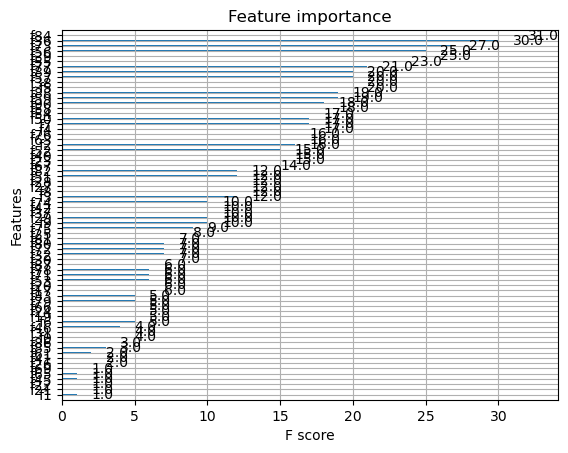

In [17]:
model_xgb.feature_names=feature_names
xgboost.plot_importance(model_xgb)

In [18]:
model_score = model_xgb.feature_importances_
feature, score = zip(*sorted(zip(feature_names, model_score), key=lambda x: x[1], reverse=True))
top_10_feature = feature[:10]
feature[:10]

('HRV_MedianNN',
 'HRV_LFn',
 'HRV_MFDFA_alpha1_Max',
 'HRV_MFDFA_alpha1_Fluctuation',
 'HRV_MCVNN',
 'HRV_HF',
 'HRV_C2d',
 'HRV_MFDFA_alpha1_Asymmetry',
 'SCR_Amplitude_mean',
 'HRV_MeanNN')

In [31]:
X

array([[26.        ,  1.        ,  0.35852993, ...,  1.96899498,
         2.71137975,  0.90485519],
       [26.        ,  1.        ,  0.66574137, ...,  2.00645982,
         2.26692439,  1.17748683],
       [26.        ,  1.        ,  0.91839849, ...,  1.90912045,
         2.01296841,  0.70313536],
       ...,
       [25.        ,  0.        ,  0.52275718, ...,  1.99401756,
         3.06986268,  0.90485519],
       [25.        ,  0.        ,  0.26489049, ...,  2.01233661,
         2.27845258,  0.9843895 ],
       [25.        ,  0.        ,  0.23300733, ...,  2.01657699,
         2.50552268,  0.96273868]])

In [32]:
model_explainable = shap.TreeExplainer(model_xgb, data=X)
shap_values = model_explainable.shap_values(X, Y)

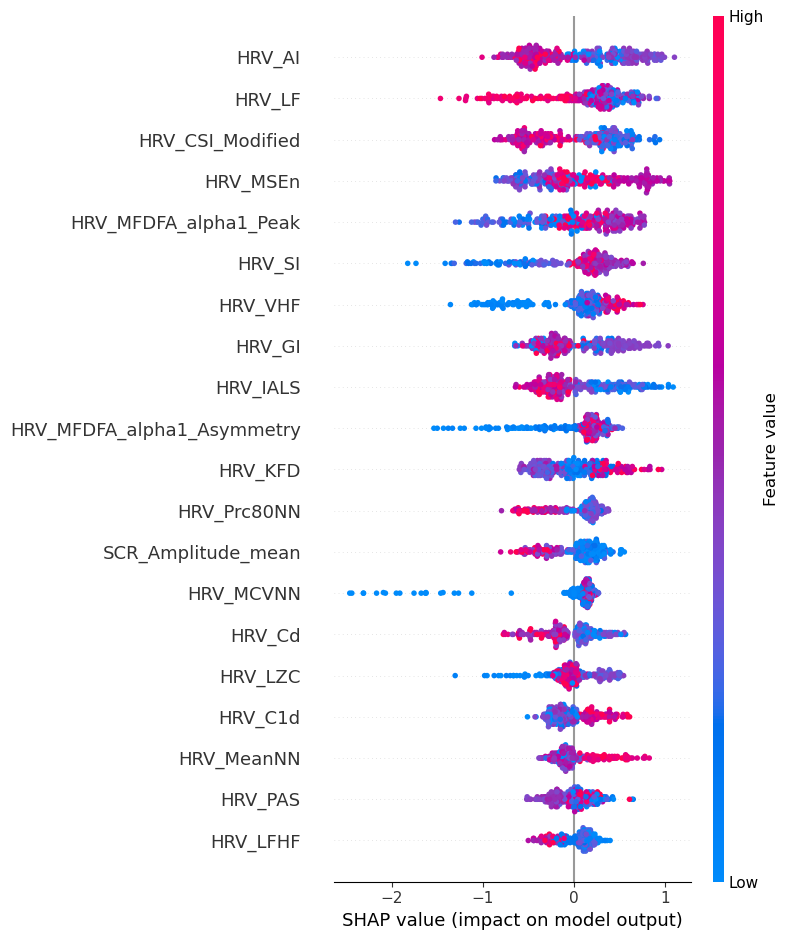

In [33]:
shap.summary_plot(shap_values, features=X, feature_names=feature_names)

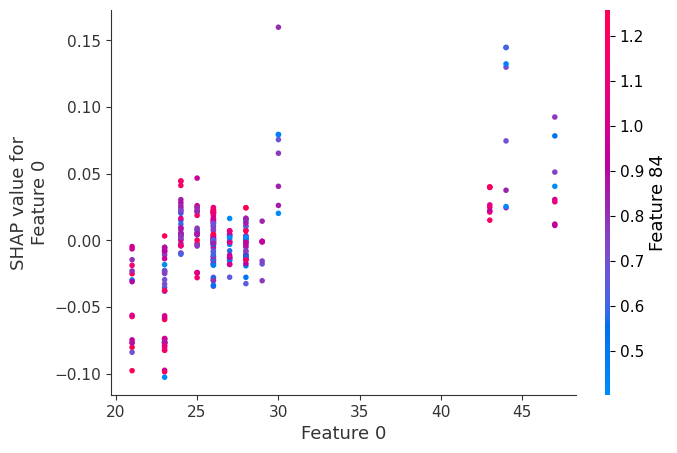

In [34]:
shap.dependence_plot(0, shap_values, X)

# Model Training 1

In [30]:
!pip install catboost

     ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
     -------------------------------------- 0.0/101.0 MB 435.7 kB/s eta 0:03:52
     -------------------------------------- 0.0/101.0 MB 435.7 kB/s eta 0:03:52
     -------------------------------------- 0.0/101.0 MB 435.7 kB/s eta 0:03:52
     -------------------------------------- 0.0/101.0 MB 178.6 kB/s eta 0:09:26
     -------------------------------------- 0.0/101.0 MB 178.6 kB/s eta 0:09:26
     -------------------------------------- 0.1/101.0 MB 309.1 kB/s eta 0:05:27
     -------------------------------------- 0.1/101.0 MB 364.4 kB/s eta 0:04:37
     -------------------------------------- 0.1/101.0 MB 328.4 kB/s eta 0:05:08
     -------------------------------------- 0.1/101.0 MB 341.3 kB/s eta 0:04:56
     -------------------------------------- 0.1/101.0 MB 341.3 kB/s eta 0:04:56
     -------------------------------------- 0.2/101.0 